In [1]:
### Initial notebook

In [2]:
#%pip install xarray
!python -c "import sys; print(sys.version)"

3.12.1 (main, Jan  1 1980, 12:01:00) [GCC 13.2.0]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import pandas as pd
from itertools import groupby
import glob
import os
import time
import xarray as xr
from contrack import contrack
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm, TwoSlopeNorm
import uxarray as ux

In [4]:
## Climate indices
def count_frost_days(tn, threshold=0.0):
    '''
    Annual count of days when TN (daily minimum temperature) < 0oC.

    Let TNijbe daily minimum temperature on day i in year j. Count the number of days where:

    TNij < 0oC.
    '''
    # Clean data (handle any non-finite values safely)
    tn_clean = tn.where(np.isfinite(tn))

    # Frost day mask and count
    frost_days = (tn_clean < threshold)
#    return frost_days.sum(dim='time', skipna=True)
    # Convert boolean to float (True=1.0, False=0.0), and sum over time
    return frost_days.astype(float).sum(dim='time', skipna=True)

def count_summer_days(tm, threshold=25.0):
    '''
    SU, Number of summer days: Annual count of days when TX (daily maximum temperature) > 25oC.

    Let TXij be daily maximum temperature on day i in year j. Count the number of days where:
    TXij > 25oC.
    '''
    # Clean data (handle any non-finite values safely)
    tm_clean = tm.where(np.isfinite(tm))

    # Assume °C by default, adjust only if unit says Kelvin
 #   if tn_clean.attrs.get('units', '').lower() in ['k', 'kelvin']:
 #       threshold += 273.15

    # Frost day mask and count
    summer_days = (tm_clean > threshold)
    return summer_days.sum(dim='time', skipna=True)

def count_icing_days(tm, threshold=0.0):
    '''
    ID, Number of icing days: Annual count of days when TX (daily maximum temperature) < 0oC.

    Let TXijbe daily maximum temperature on day i in year j. Count the number of days where:

    TXij < 0oC.
    '''
    # Clean data (handle any non-finite values safely)
    tm_clean = tm.where(np.isfinite(tm))

    # Assume °C by default, adjust only if unit says Kelvin
 #   if tn_clean.attrs.get('units', '').lower() in ['k', 'kelvin']:
 #       threshold += 273.15

    # Frost day mask and count
    icing_days = (tm_clean < threshold)
    return icing_days.sum(dim='time', skipna=True)
#def compute_TXX(tmax):
#    return tmax.groupby('time.year').max(dim='time')

def compute_dtr(tx, tn):
    """
    Compute Daily Temperature Range (DTR) as the monthly mean of (TX - TN).

    Parameters:
        tx (xarray.DataArray): Daily maximum temperature (TX), with 'time' dimension.
        tn (xarray.DataArray): Daily minimum temperature (TN), same dimensions as tx.

    Returns:
        xarray.DataArray: Monthly mean daily temperature range.
    """
    # Ensure both inputs align in time and space
    tx, tn = xr.align(tx, tn)

    # Compute daily range
    dtr_daily = tx - tn

    # Compute monthly mean DTR
    dtr_monthly = dtr_daily.resample(time='ME').mean(dim='time', skipna=True)

    # Add metadata
    dtr_monthly.name = 'DTR'
    dtr_monthly.attrs.update({
        'long_name': 'Monthly mean daily temperature range',
        'units': tx.attrs.get('units', '°C'),
        'comment': 'Mean of daily (TX - TN), where TX is max and TN is min temperature.',
        'cell_methods': 'time: mean (of daily max - min)',
    })

    return dtr_monthly
def get_max_dry_spell(seq):
    """
    Get the length of the longest consecutive run of True (dry days) in a 1D boolean array.
    """
    return max((sum(1 for _ in group) for val, group in groupby(seq) if val), default=0)


def compute_CDD(precip, threshold=1.0):
    """
    Compute the maximum length of dry spells (CDD) using groupby logic.
    
    Parameters:
        precip (xarray.DataArray): Daily precipitation with time dim.
        threshold (float): Dry day threshold in mm (default: 1.0).
    
    Returns:
        xarray.DataArray: CDD values (max dry spell length) at each grid point.
    """
    # Get dry day mask
    dry_days = (precip < threshold)

#    dry_days=dry_days.astype(float)

    # Apply the get_max_dry_spell function along 'time' using xarray.apply_ufunc
    cdd = xr.apply_ufunc(
        get_max_dry_spell,
        dry_days,
        input_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[int]
    )

    cdd.name = 'CDD'
    cdd.attrs.update({
        'long_name': 'Maximum number of consecutive dry days',
        'units': 'days',
        'comment': 'CDD is the length of the longest dry spell (RR < 1 mm)',
    })

    return cdd,dry_days

def compute_CWD(precip, threshold=1.0):
    """
    Compute the maximum length of wet spells (CWD) using groupby logic.
    
    Parameters:
        precip (xarray.DataArray): Daily precipitation with time dim.
        threshold (float): Dry day threshold in mm (default: 1.0).
    
    Returns:
        xarray.DataArray: CWD values (max dry spell length) at each grid point.
    """
    # Get dry day mask
    wet_days = (precip > threshold)

#    dry_days=dry_days.astype(float)

    # Apply the get_max_dry_spell function along 'time' using xarray.apply_ufunc
    cwd = xr.apply_ufunc(
        get_max_dry_spell,
        wet_days,
        input_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[int]
    )

    cwd.name = 'CWD'
    cwd.attrs.update({
        'long_name': 'Maximum number of consecutive wet days',
        'units': 'days',
        'comment': 'CWD is the length of the longest wet spell (RR > 1 mm)',
    })

    return cwd,wet_days

def compute_precip_exceedance(precip, start='2010', end='2023', bin_width=0.01, max_precip=1000):
    """
    Compute exceedance frequency of daily precipitation.
    
    Parameters:
        precip (xarray.DataArray): Daily precipitation (mm/day), must have 'time' dim.
        start (str): Start year.
        end (str): End year.
        bin_width (float): Width of precipitation bins (mm/day).
        max_precip (float): Upper limit of precipitation to consider (mm/day).
    
    Returns:
        bins (np.ndarray): Precipitation bin edges.
        exceedance_freq (np.ndarray): Exceedance frequency (%) for each bin.
    """
    # Select time slice
    p = precip.sel(time=slice(start, end))
    
    # Flatten across time and space
    values = p.values.flatten()
    values = values[np.isfinite(values)]  # Remove NaNs

    # Define bins
    bins = np.arange(0, max_precip + bin_width, bin_width)

    # Histogram (counts of values in each bin)
    hist, bin_edges = np.histogram(values, bins=bins)

    # Cumulative sum (reverse): exceedance count
    exceedance_counts = np.cumsum(hist[::-1])[::-1]

    # Convert to percentage
    exceedance_freq = 100 * exceedance_counts / exceedance_counts[0]

    return bins[:-1], exceedance_freq

# 2.5km resolution

## Unstructured grid

In [58]:
###Unstructured grid
#us_xr=xr.open_dataset('/capstor/store1/cscs/userlab/cwp03/zemanc/Data_Dyamond_PostProcessed/out_2/tot_prec_20240325T000000Z.nc',chunks="auto")
#us_xr

icon_grid_path = "/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/icon_grid_0056_R02B10_G.nc"
icon_file_path = '/capstor/store1/cscs/userlab/cwp03/zemanc/Data_Dyamond_PostProcessed/out_2/tot_prec_20240325T000000Z.nc'

ux_ds = ux.open_dataset( icon_grid_path, icon_file_path)
ux_ds 

<xarray.UxDataset> Size: 38GB
Dimensions:    (n_face: 83886080, vertices: 3, time: 96)
Coordinates:
  * time       (time) datetime64[ns] 768B 2024-03-25 ... 2024-03-25T23:45:00
    clon       (n_face) float64 671MB ...
    clat       (n_face) float64 671MB ...
Dimensions without coordinates: n_face, vertices
Data variables:
    clon_bnds  (n_face, vertices) float64 2GB ...
    clat_bnds  (n_face, vertices) float64 2GB ...
    tot_prec   (time, n_face) float32 32GB ...

In [59]:
### quick plot
ux_ds['tot_prec'].isel(time=0).plot(cmap="viridis", backend="bokeh") 

:Image   [x,y]   (x_y tot_prec)

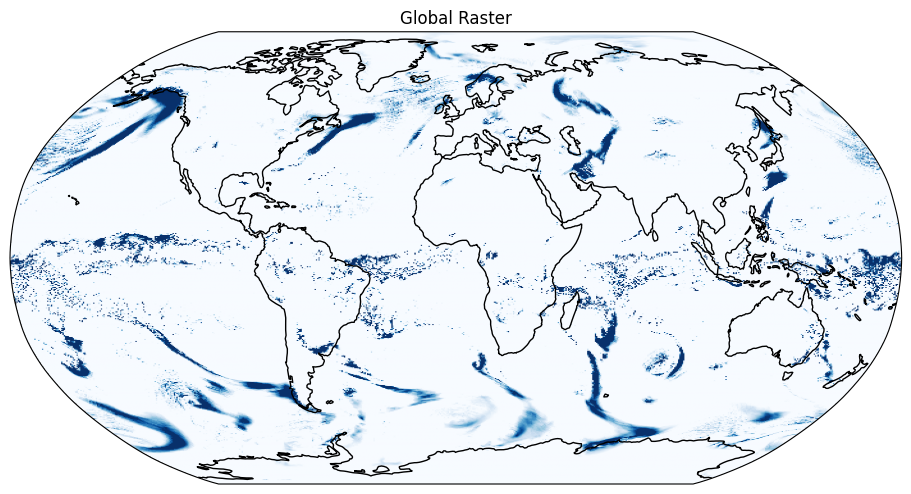

In [61]:
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.Robinson()}, figsize=(9, 6), constrained_layout=True
)

ax.set_global()
#raster = ux_ds['tot_prec'].isel(time=0).to_raster(ax=ax)
raster = ux_ds['tot_prec'].isel(time=slice(0,24)).sum(dim='time').to_raster(ax=ax)
img = ax.imshow(
    raster, cmap="Blues", vmax=5, vmin=0.5, origin="lower", extent=ax.get_xlim() + ax.get_ylim()
)
ax.set_title("Global Raster")
ax.coastlines()

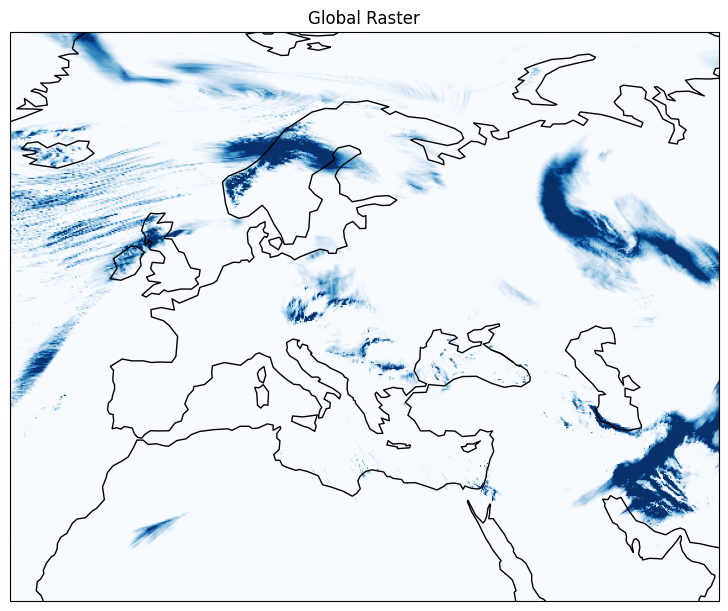

In [64]:
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.Robinson()}, figsize=(9, 6), constrained_layout=True
)
latS=20
latN=80
lonW=-20
lonE=60
bounds = [(lonW, lonE, latS, latN)]
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
#raster = ux_ds['tot_prec'].isel(time=0).to_raster(ax=ax)
raster = ux_ds['tot_prec'].isel(time=slice(0,24)).sum(dim='time').to_raster(ax=ax)
img = ax.imshow(
    raster, cmap="Blues", vmax=5, vmin=0.5, origin="lower", extent=ax.get_xlim() + ax.get_ylim()
)
ax.set_title("Global Raster")
ax.coastlines()

In [14]:
geo=xr.open_dataset('/capstor/store1/cscs/userlab/cwp03/zemanc/Data_Dyamond_PostProcessed/out_1_1/remap_geopot_20240101T000000Z.nc')
geo

<xarray.Dataset> Size: 5GB
Dimensions:  (time: 8, plev: 37, lat: 1440, lon: 2880)
Coordinates:
  * time     (time) datetime64[ns] 64B 2024-01-01 ... 2024-01-01T21:00:00
  * lon      (lon) float64 23kB -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 12kB -89.95 -89.83 -89.7 -89.58 ... 89.67 89.8 89.92
  * plev     (plev) float64 296B 100.0 200.0 300.0 ... 9.5e+04 9.75e+04 1e+05
Data variables:
    geopot   (time, plev, lat, lon) float32 5GB ...
Attributes:
    CDI:                       Climate Data Interface version 2.4.0 (https://...
    Conventions:               CF-1.6
    source:                    version: 2024.10; revision: spack-ci_v0.1-1084...
    institution:               Max Planck Institute for Meteorology/Deutscher...
    title:                     ICON simulation
    history:                   Mon Aug 04 12:39:27 2025: cdo -P 36 remap,/cap...
    references:                see MPIM/DWD publications
    comment:                   Praveen Kumar Pothapakula, ETHZ (ppothapa) on ...
    CDO:                       Climate Data Operators version 2.4.0 (https://...
    cdo_openmp_thread_number:  36

## remapped to 0.5 degrees

In [1]:
def dailyify(da, how="mean", make_bool=False):
    da2 = da.assign_coords(time=da.time.dt.floor("D"))
    if how == "mean":
        da2 = da2.groupby("time").mean()
    elif how == "sum":
        da2 = da2.groupby("time").sum()
    elif how == "max":
        da2 = da2.groupby("time").max()
    if make_bool:
        da2 = da2.fillna(False).astype(bool)
    return da2

def corr_on_heatwave_days(sm_anom, p_anom, hw_mask, nmin=30):
    sm_anom, p_anom, hw_mask = xr.align(sm_anom, p_anom, hw_mask, join="inner")

    sm_hw = sm_anom.where(hw_mask)
    p_hw  = p_anom.where(hw_mask)

    # correlation over time (skip NaN pairs)
    r = xr.corr(sm_hw, p_hw, dim="time")

    # sample size (number of valid paired days)
    n = xr.ufuncs.logical_and(sm_hw.notnull(), p_hw.notnull()).sum("time")

    return r.where(n >= nmin), n


In [5]:
tp05=xr.open_mfdataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/tot_prec/tot_prec_*_0p5deg.nc')['tot_prec']
tp05#.sel(time='2020')#sel(time=0).plot()

<xarray.DataArray 'tot_prec' (time: 1534, lat: 360, lon: 720)> Size: 2GB
dask.array<concatenate, shape=(1534, 360, 720), dtype=float32, chunksize=(365, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 12kB 2020-01-20T11:52:30 ... 2024-04-01
  * lon      (lon) float64 6kB 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Attributes:
    standard_name:  tot_prec
    long_name:      total precip
    units:          kg m-2
    param:          52.1.0
    cell_methods:   time: sum

In [6]:
date = '2020' # for testing
tp05_daily = tp05.sel(time=date)

### compue dry spells
cdd,dry_days=compute_CDD(tp05_daily.chunk(dict(time=-1)), threshold=1.0)
cdd = cdd.astype(float).compute() 
cdd

<xarray.DataArray 'CDD' (lat: 360, lon: 720)> Size: 2MB
array([[187., 187., 187., ..., 187., 187., 187.],
       [186., 186., 186., ..., 186., 186., 186.],
       [186., 186., 186., ..., 186., 186., 186.],
       ...,
       [ 25.,  25.,  25., ...,  25.,  25.,  25.],
       [ 49.,  49.,  49., ...,  49.,  49.,  49.],
       [ 50.,  50.,  50., ...,  50.,  50.,  50.]], shape=(360, 720))
Coordinates:
  * lon      (lon) float64 6kB 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Attributes:
    long_name:  Maximum number of consecutive dry days
    units:      days
    comment:    CDD is the length of the longest dry spell (RR < 1 mm)

In [7]:
########## Plotting right way we need to change latitude values form 0 t0 360 to -180 to 180\

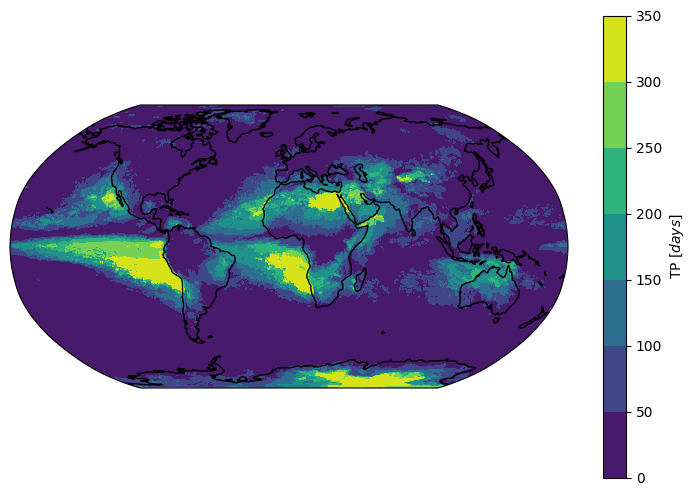

In [7]:
# Shift 0..360 -> -180..180 and sort
cdd_shifted = cdd.assign_coords(
    lon=((cdd.lon + 180) % 360) - 180
).sortby("lon")

fig, ax = plt.subplots(
    1, 1,
    figsize=(9, 6),
    subplot_kw={"projection": ccrs.Robinson()}
)

im = cdd_shifted.plot.contourf(
    ax=ax,
    x="lon",
    y="lat",
#    cmap="Blues",
#    levels=np.arange(0, 330,30),
    transform=ccrs.PlateCarree(),
    add_colorbar=True,
    cbar_kwargs={"label": "TP [$days$]"},
)

ax.set_global()
ax.coastlines()

In [9]:
### compue wet spells
cwd,wet_days=compute_CWD(tp05_daily.chunk(dict(time=-1)), threshold=1.0)
cwd = cwd.astype(float).compute() 
cwd

<xarray.DataArray 'CWD' (lat: 360, lon: 720)> Size: 2MB
array([[1., 1., 1., ..., 1., 1., 1.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [6., 6., 6., ..., 6., 6., 6.],
       [5., 5., 5., ..., 5., 5., 5.],
       [6., 6., 6., ..., 6., 6., 6.]], shape=(360, 720))
Coordinates:
  * lon      (lon) float64 6kB 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Attributes:
    long_name:  Maximum number of consecutive wet days
    units:      days
    comment:    CWD is the length of the longest wet spell (RR > 1 mm)

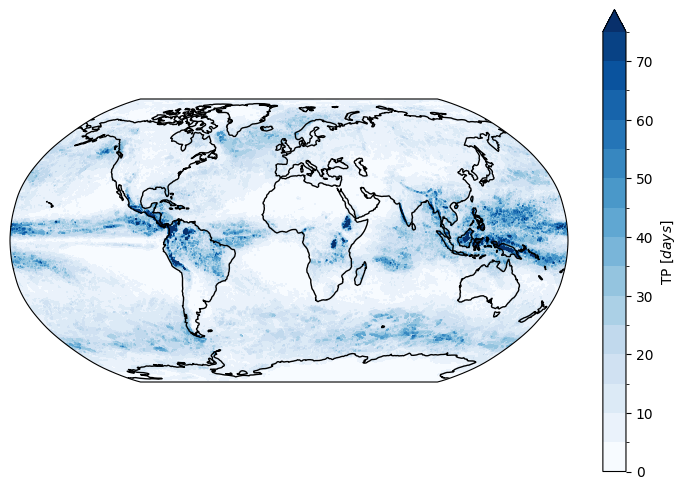

In [11]:
# Shift 0..360 -> -180..180 and sort
cwd_shifted = cwd.assign_coords(
    lon=((cwd.lon + 180) % 360) - 180
).sortby("lon")

fig, ax = plt.subplots(
    1, 1,
    figsize=(9, 6),
    subplot_kw={"projection": ccrs.Robinson()}
)

im = cwd_shifted.plot.contourf(
    ax=ax,
    x="lon",
    y="lat",
    cmap="Blues",
#    vmin=0,
#    vmax=50,
    levels=np.arange(0, 80,5),
    transform=ccrs.PlateCarree(),
    add_colorbar=True,
    cbar_kwargs={"label": "TP [$days$]"},
)

ax.set_global()
ax.coastlines()

# Unstructured 40 km

In [4]:
#icon_grid_path = "/capstor/scratch/cscs/ppothapa/for_edgar/sou_s_20230817T000000Z.nc"
icon_grid_path = "/capstor/scratch/cscs/edolores/old_icon/icon_grid_0052_R02B06_G.nc"

icon_file_path = "/capstor/scratch/cscs/ppothapa/for_edgar/tot_prec/tot_prec_2017_compressed.nc"

ux_ds = ux.open_dataset( icon_grid_path, icon_file_path)
ux_ds 

<xarray.UxDataset> Size: 12GB
Dimensions:    (n_face: 327680, vertices: 3, time: 8760)
Coordinates:
  * time       (time) datetime64[ns] 70kB 2017-01-01 ... 2017-12-31T23:00:00
    clon       (n_face) float64 3MB ...
    clat       (n_face) float64 3MB ...
Dimensions without coordinates: n_face, vertices
Data variables:
    clon_bnds  (n_face, vertices) float64 8MB ...
    clat_bnds  (n_face, vertices) float64 8MB ...
    tot_prec   (time, n_face) float32 11GB ...

In [8]:
#uxgrid = ux.open_grid(icon_grid_path)
#uxgrid.dims

In [9]:
### quick plot
ux_ds['tot_prec'].isel(time=0).plot(cmap="viridis", backend="bokeh") 

:Image   [x,y]   (x_y tot_prec)

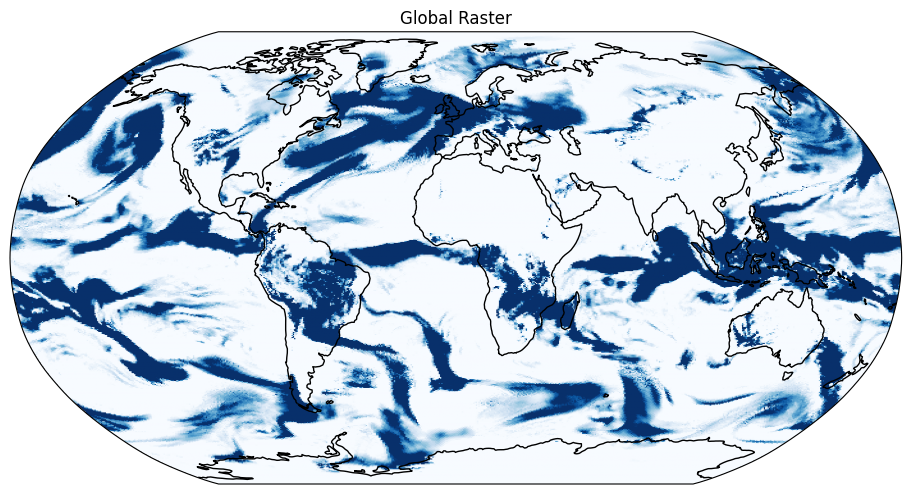

In [10]:
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.Robinson()}, figsize=(9, 6), constrained_layout=True
)

ax.set_global()
#raster = ux_ds['tot_prec'].isel(time=0).to_raster(ax=ax)
raster = ux_ds['tot_prec'].isel(time=slice(0,24)).sum(dim='time').to_raster(ax=ax)
img = ax.imshow(
    raster, cmap="Blues", vmax=5, vmin=0.5, origin="lower", extent=ax.get_xlim() + ax.get_ylim()
)
ax.set_title("Global Raster")
ax.coastlines()


In [14]:
### Compute daily precip
#date = '2017' # for testing
tp_daily = ux_ds['tot_prec'].resample(time='1D').sum().squeeze()
tp_daily

<xarray.UxDataArray 'tot_prec' (time: 365, n_face: 327680)> Size: 478MB
array([[6.6263406e-03, 1.7505139e-03, 7.0111295e-03, ..., 7.8603144e+00,
        7.5973806e+00, 6.9005213e+00],
       [2.5378987e-01, 2.4827760e-01, 5.7232338e-01, ..., 2.0644663e-01,
        7.8029752e-01, 1.1253102e+00],
       [2.8699357e-02, 5.3136919e-02, 6.3412040e-02, ..., 5.4169064e+00,
        5.5360484e+00, 7.6211395e+00],
       ...,
       [2.5899512e-01, 1.7901383e-01, 2.7574369e-01, ..., 1.6290153e+00,
        4.8592654e-01, 3.4448338e-01],
       [2.6476204e+00, 2.3585436e+00, 3.9150388e+00, ..., 3.0000246e-01,
        4.3337476e-01, 2.6408774e-01],
       [3.2866293e-01, 3.8426197e-01, 4.3508312e-01, ..., 5.8817830e+00,
        7.2280898e+00, 7.5894408e+00]], shape=(365, 327680), dtype=float32)
Coordinates:
    clon     (n_face) float64 3MB ...
    clat     (n_face) float64 3MB ...
  * time     (time) datetime64[ns] 3kB 2017-01-01 2017-01-02 ... 2017-12-31
Dimensions without coordinates: n_face
Attributes:
    standard_name:                tot_prec
    long_name:                    total precip
    units:                        kg m-2
    param:                        52.1.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [17]:
### compue dry spells
cdd,dry_days=compute_CDD(tp_daily.chunk(dict(time=-1)), threshold=1.0)
cdd = cdd.astype(float).compute() 
cdd

<xarray.DataArray 'CDD' (n_face: 327680)> Size: 3MB
array([49., 44., 95., ...,  8.,  8.,  8.], shape=(327680,))
Coordinates:
    clon     (n_face) float64 3MB 1.274 1.274 1.266 1.282 ... 1.34 1.347 1.334
    clat     (n_face) float64 3MB 0.9184 0.9239 0.9156 ... -0.7912 -0.7916
Dimensions without coordinates: n_face
Attributes:
    long_name:  Maximum number of consecutive dry days
    units:      days
    comment:    CDD is the length of the longest dry spell (RR < 1 mm)

In [19]:
cdd_ux = ux.UxDataArray(cdd, uxgrid=ux_ds.uxgrid)
cdd_ux

<xarray.UxDataArray 'CDD' (n_face: 327680)> Size: 3MB
array([49., 44., 95., ...,  8.,  8.,  8.], shape=(327680,))
Coordinates:
    clon     (n_face) float64 3MB 1.274 1.274 1.266 1.282 ... 1.34 1.347 1.334
    clat     (n_face) float64 3MB 0.9184 0.9239 0.9156 ... -0.7912 -0.7916
Dimensions without coordinates: n_face
Attributes:
    long_name:  Maximum number of consecutive dry days
    units:      days
    comment:    CDD is the length of the longest dry spell (RR < 1 mm)

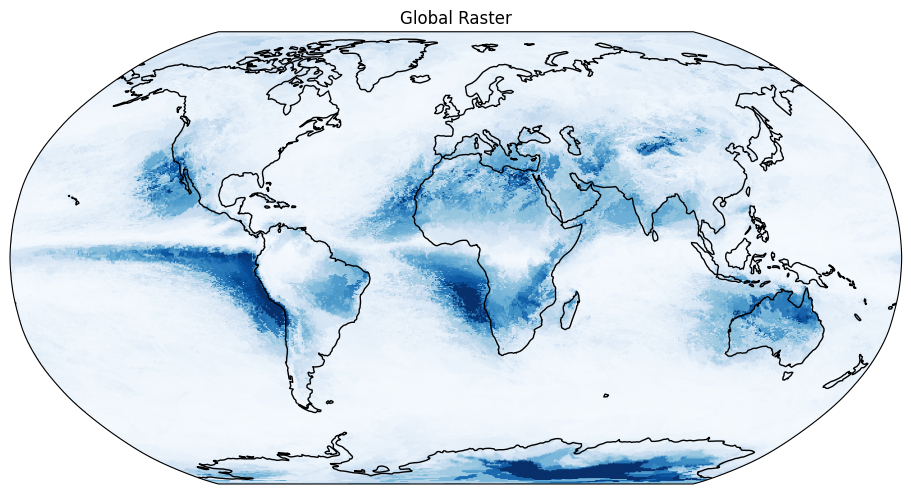

In [22]:
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.Robinson()}, figsize=(9, 6), constrained_layout=True
)

ax.set_global()
raster = cdd_ux.to_raster(ax=ax)
#raster = tp_daily.isel(time=slice(0,24)).sum(dim='time').to_raster(ax=ax)
img = ax.imshow(
    raster, cmap="Blues", vmax=300, vmin=0, origin="lower", extent=ax.get_xlim() + ax.get_ylim()
)
ax.set_title("Global Raster")
ax.coastlines()